In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import scmulti
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/kotliarov-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 53196 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
cite = sc.read_h5ad('../data/kotliarov-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 53196 × 87
    obs: 'n_genes', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
rna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
rna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
scrna.obs['cell_type'] = scrna.obs['cluster_level1'].astype('category')
cite.obs['cell_type'] = cite.obs['cluster_level1'].astype('category')

## Allign the labels

In [10]:
rna.obs.cell_type.cat.categories

Index(['CD56 (bright) NK cells', 'CD56 (dim) NK cells', 'MAIT T cells',
       'classical monocytes', 'effector CD8 T cells', 'intermediate monocytes',
       'memory B cells', 'memory CD4 T cells', 'myeloid DC', 'naive B cells',
       'naive CD4 T cells', 'naive CD8 T cells', 'non-classical monocytes',
       'plasmacytoid DC'],
      dtype='object')

In [11]:
scrna.obs.cell_type.cat.categories

Index(['CD4 naive', 'CD4 memory T', 'Classical monocytes and mDC', 'B',
       'CD8 memory T', 'NK', 'CD8 naive', 'Unconventional T cells',
       'Non-classical monocytes', 'pDC'],
      dtype='object')

In [12]:
# make types more general for now
new_cell_types = {'CD56 (bright) NK cells': 'NK', 'CD56 (dim) NK cells': 'NK', 'MAIT T cells': 'Unconventional T cells',
                  'classical monocytes': 'Classical monocytes and mDC', 'effector CD8 T cells': 'CD8 effector', 'intermediate monocytes': 'Intermediate monocytes',
                  'memory B cells': 'B', 'memory CD4 T cells': 'CD4 memory T', 'myeloid DC': 'Classical monocytes and mDC', 'naive B cells':'B',
                  'naive CD4 T cells': 'CD4 naive', 'naive CD8 T cells': 'CD8 naive', 'non-classical monocytes': 'Non-classical monocytes',
                   'plasmacytoid DC': 'pDC'
                 }

In [13]:
rna.obs['old_cell_type'] = rna.obs['cell_type']
scatac.obs['old_cell_type'] = scatac.obs['cell_type']

In [14]:
new_rna_cell_types = [new_cell_types[name] for name in rna.obs.cell_type]

In [15]:
new_atac_cell_types = [new_cell_types[name] for name in scatac.obs.cell_type]

In [16]:
rna.obs.cell_type = new_rna_cell_types
scatac.obs.cell_type = new_atac_cell_types

## Choose shared features

In [17]:
common = rna.concatenate(scrna)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


In [18]:
rna = common[common.obs['batch'] == '0']
scrna = common[common.obs['batch'] == '1']

# Paired setting

## Configure and train the model

In [19]:
model = scmulti.models.MultiVAE(
    adatas=[[scrna, rna], [cite], [scatac]],
    names=[['scRNA-seq-kotliarov', 'scRNA-seq-10x'], ['scCITE-seq-kotliarov'], ['scATAC-seq-10x']],
    pair_groups=[[0, 1], [0], [1]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [20]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

 |██------------------| 10.0% iter=1001/10000, time=544.75(s), loss=0.8516, recon=0.7645, kl=62.5569, integ=8.6440, val_loss=211.0760, val_recon=0.5159, val_kl=86.4799, val_integ=4.6015
 |████----------------| 20.0% iter=2001/10000, time=605.52(s), loss=0.6123, recon=0.5713, kl=127.4780, integ=3.9674, val_loss=185.0706, val_recon=0.4707, val_kl=138.3830, val_integ=2.1379
 |██████--------------| 30.0% iter=3001/10000, time=535.58(s), loss=0.5558, recon=0.5308, kl=163.8586, integ=2.3321, val_loss=175.0847, val_recon=0.4526, val_kl=169.7491, val_integ=1.2567
 |████████------------| 40.0% iter=4001/10000, time=451.33(s), loss=0.5449, recon=0.5286, kl=191.6518, integ=1.4371, val_loss=168.9513, val_recon=0.4405, val_kl=199.6859, val_integ=0.8012
 |██████████----------| 50.0% iter=5001/10000, time=440.82(s), loss=0.5282, recon=0.5161, kl=222.3858, integ=0.9885, val_loss=165.1078, val_recon=0.4317, val_kl=232.4868, val_integ=0.6185
 |████████████--------| 60.0% iter=6001/10000, time=448.30(s),

## Plot training history

In [21]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,val_loss,val_recon,val_kl,val_integ
0,1000,0.851557,0.764491,62.556861,8.643979,211.075955,0.515928,86.479932,4.601483
1,2000,0.612265,0.571317,127.477966,3.967394,185.070615,0.470689,138.383011,2.137882
2,3000,0.555800,0.530841,163.858612,2.332069,175.084675,0.452571,169.749093,1.256710
3,4000,0.544864,0.528576,191.651822,1.437138,168.951268,0.440467,199.685852,0.801181
4,5000,0.528161,0.516052,222.385764,0.988467,165.107810,0.431718,232.486795,0.618475
5,6000,0.528341,0.518166,252.753632,0.764781,164.032157,0.429485,258.343249,0.529608
6,7000,0.517594,0.508274,279.639368,0.652353,162.066912,0.424373,285.792369,0.488306
7,8000,0.505424,0.496366,302.833789,0.602956,160.614121,0.420613,307.065608,0.456873
8,9000,0.494001,0.485032,321.883667,0.575066,159.356048,0.417250,328.354055,0.436741
9,9999,0.491318,0.482786,337.846527,0.515301,159.167619,0.416762,344.563230,0.419117


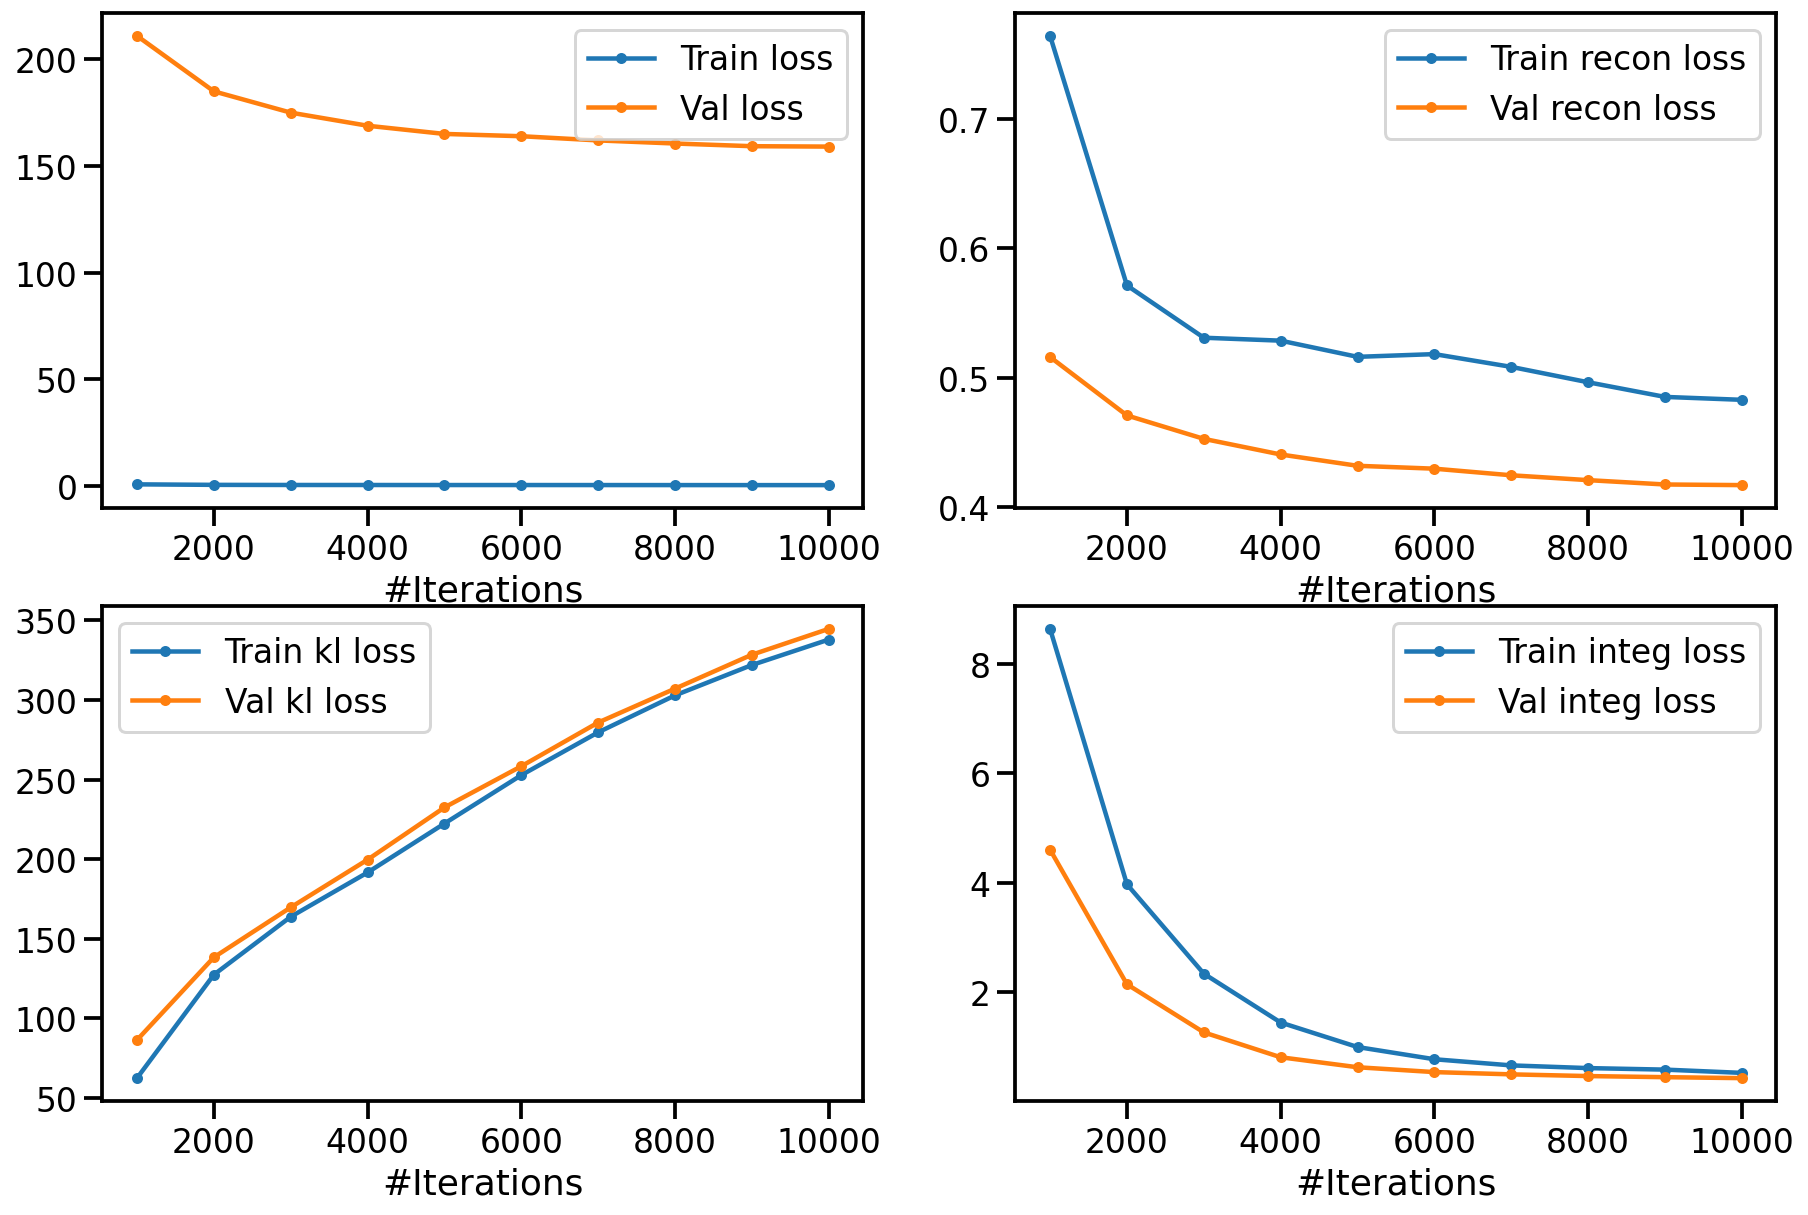

In [22]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [23]:
z = model.predict(
    adatas=[[scrna, rna], [cite], [scatac]],
    names=[['scRNA-seq-kotliarov', 'scRNA-seq-10x'], ['scCITE-seq-kotliarov'], ['scATAC-seq-10x']],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 126392 × 20
    obs: 'modality', 'cell_type', 'batch'

In [24]:
sc.tl.pca(z, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


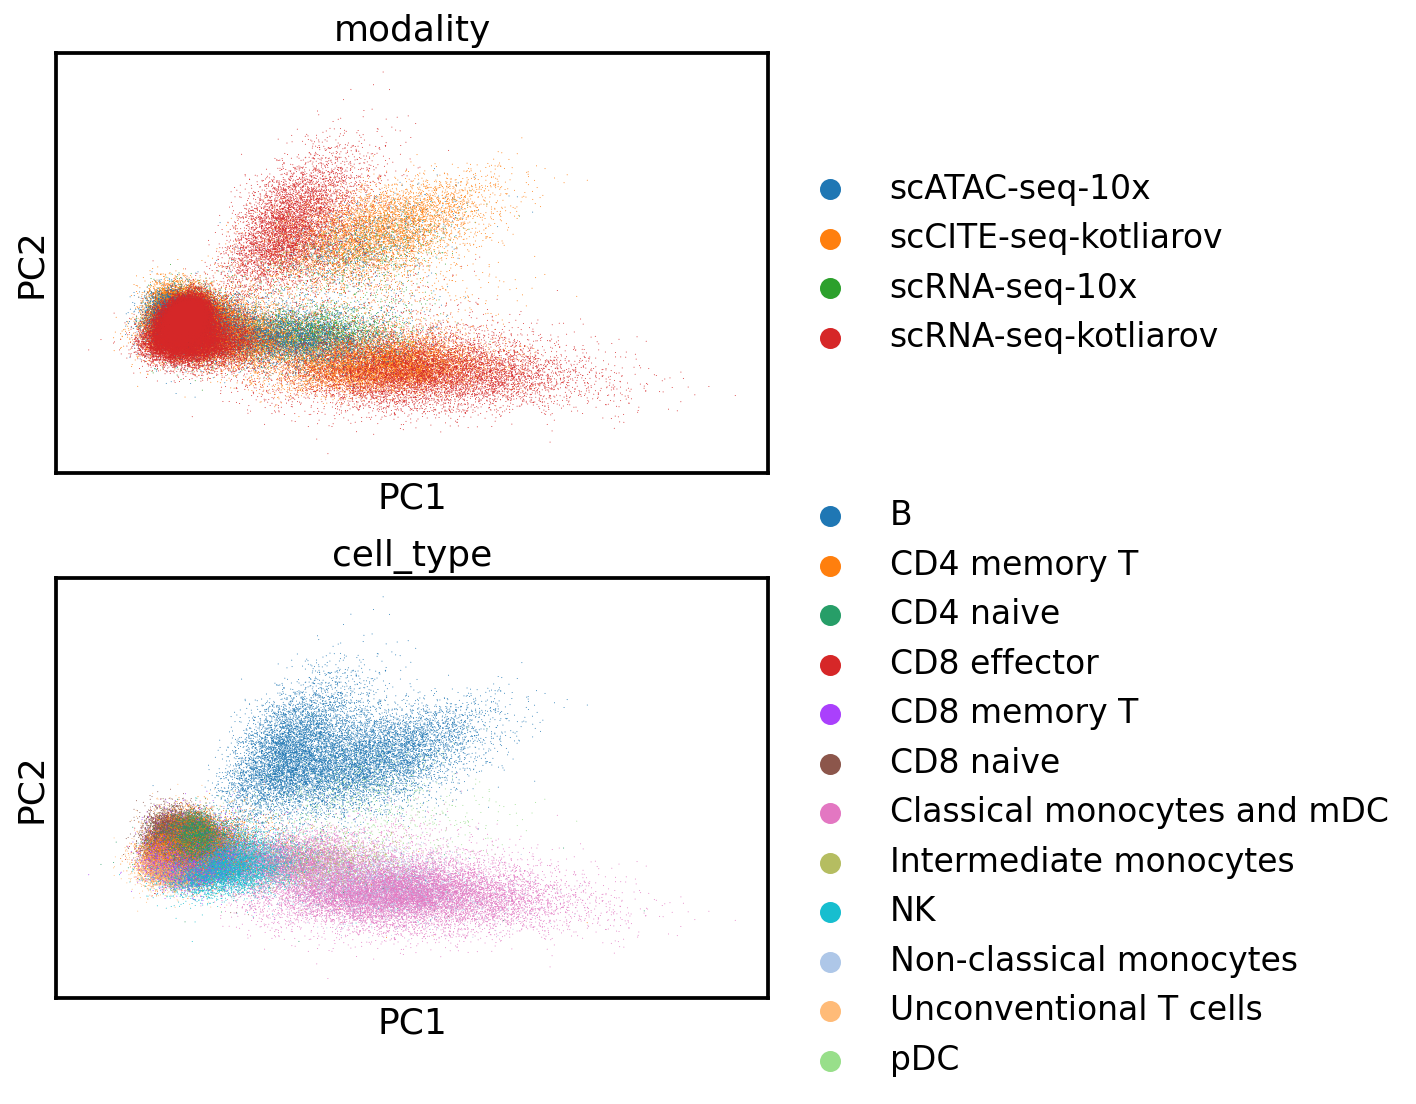

In [25]:
sc.pl.pca(z, color=['modality', 'cell_type'], ncols = 1)

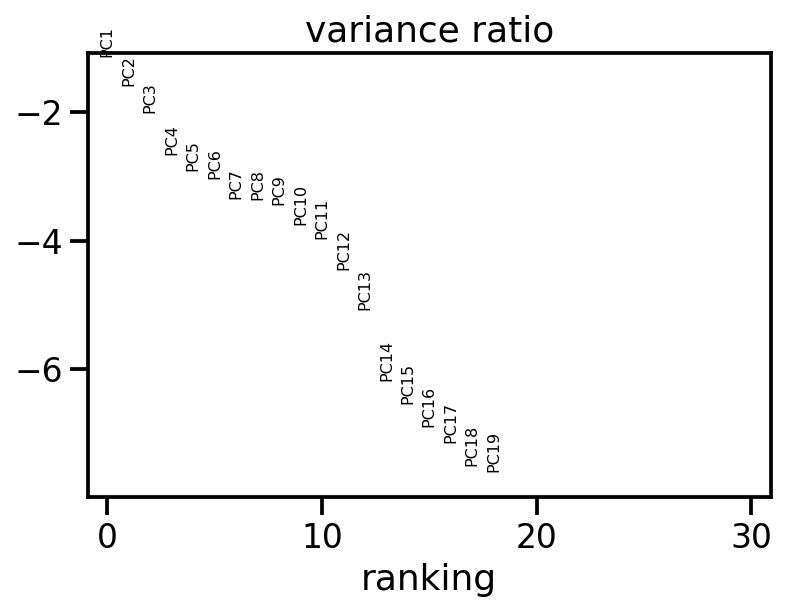

In [26]:
sc.pl.pca_variance_ratio(z, log=True)

In [27]:
sc.pp.neighbors(z, n_neighbors=10, n_pcs=14)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [28]:
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


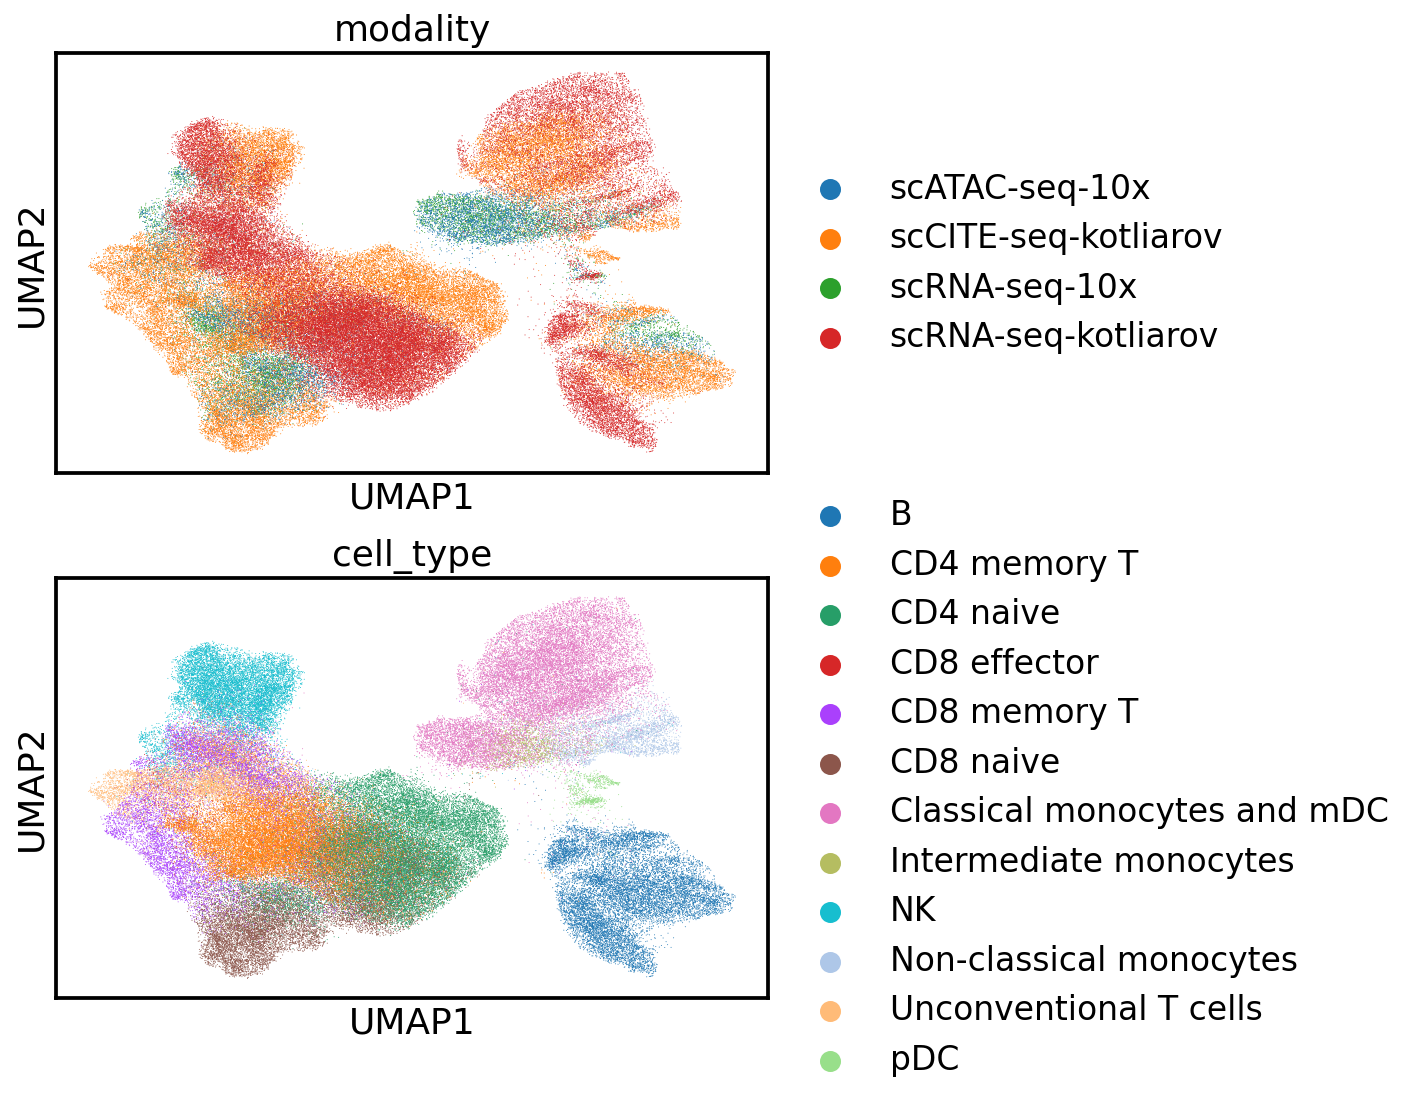

In [29]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

# Metrics

In [30]:
scmulti.metrics.nmi(z, label_key='modality')

0.0026043347138949503

In [31]:
scmulti.metrics.asw(z, label_key='modality')

-0.04157593846321106

In [32]:
scmulti.metrics.asw(z, label_key='cell_type')

0.08188688009977341